# Анализ датасета

In [27]:
import pandas as pd
df = pd.read_csv('train_spam.csv')
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [28]:
df.shape

(16278, 2)

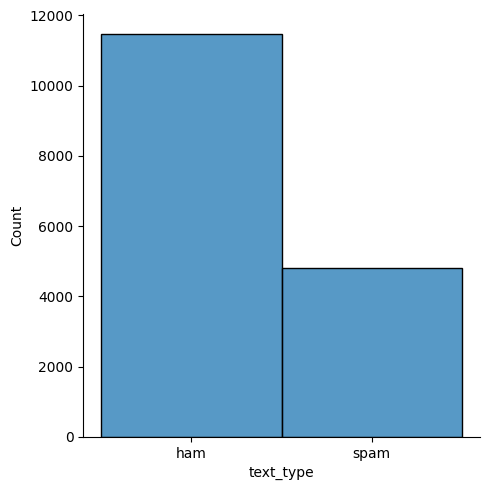

In [30]:
import seaborn as sns
sns.displot(data=df, x='text_type')

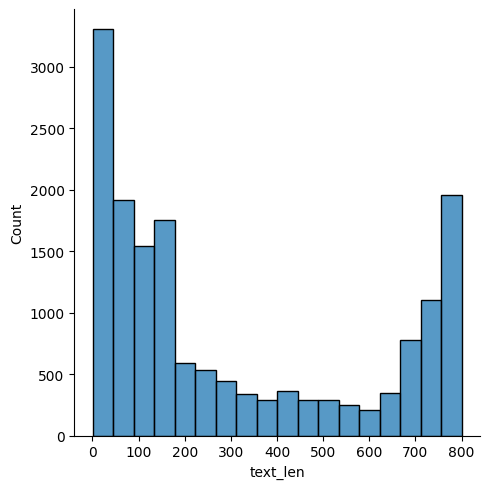

In [35]:
df['text_len'] = df.text.apply(len)
sns.displot(data=df, x='text_len')
df = df.drop(columns=['text_len'])

Классы распределены неравномерно, большая часть текстов небольшой длины

In [12]:
df.text.map(lambda x: len(x)).min(), df.text.map(lambda x: len(x)).max()

(1, 800)

In [17]:
df[df.text.str.len() == 1]

,text_type,text
5661,ham,🙁
6798,ham,👍
6888,ham,o
8114,ham,k
8402,ham,f
8865,ham,😊
14258,ham,😐
14344,ham,i


In [18]:
df[df.text.str.len() == 800]

,text_type,text
7,spam,welcome to jefferson pilot s gateway to wealth...
40,ham,on thu aug 1635465 1635465 at 1635465 1635465 ...
47,spam,adult club offers free membership instant acce...
71,ham,i did something crudely along those lines for ...
80,ham,url url date 1635465 1635465 1635465t1635465 1...
...,...,...
16184,ham,g gregory alan bolcer gbolcer endeavors com wr...
16194,spam,attn sir madan strictly confidential i am plea...
16202,ham,gw greg ward gward python net writes gw if you...
16241,ham,on mon sep 1635465 1635465 at 1635465 1635465 ...


In [23]:
df['text'][7]

'welcome to jefferson pilot s gateway to wealth as one of the industry s premier producers you must continually seek qualified cutting edge services financial profiles concept profiles professional is a personal and business analysis tool that analyzes a client s insurance investment and financial planning goals to help them see their situation today compared to their objectives market profiles professional is an ideal tool for true financial planning it not only provides a thorough analysis including asset allocation but it can calculate tax implications in a client s plan due to its modular format it can be used for specific planning needs as well as more comprehensive planning benefits this software not only provides exceptional analysis but excels in providing simple as well as comprehe'

In [24]:
df['text'][40]

'on thu aug 1635465 1635465 at 1635465 1635465 1635465pm 1635465 fergal moran mentioned in a nutshell solaris is suns own flavour of unix though i m sure that this nice person would like a bit more detail solaris is quite different to linux though these days you can make solaris act a lot like linux with an extra cd of gnu tools sun ship with solaris it is based on the sysv unix family so it s quite similar to other unixen like hpux and sco sun s hardware in general is more reliable and a lot more expensive one of the main bonuses you get by buying sun is that you are getting your hardware and software from one company so if you have a support contract they have to fix it they can t fob you off with that s a software problem talk to the software vendor etc if you are set on linux you most l'

Тексты обрезаны до максимальной длины 800, сделана базовая нормализация: удалена пунктуация и применен метод .lower(). Присвоим номера 0 обычным текстам и 1 - спаму.

In [31]:
df.text_type = df.text_type.map(dict(spam=1, ham=0))

In [32]:
df.head()

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


# Классические модели & простая векторизация

Для начала применим стемминг к тексту

In [40]:
from nltk.stem.porter import *

stemmer = PorterStemmer()

def preprocess_sentence_eng(text):
    return ' '.join(map(stemmer.stem, text.split(' ')))

In [41]:
df['text_stemmed'] = df['text'].apply(preprocess_sentence_eng)

In [42]:
df['text_stemmed'].head(4)

0    make sure alex know hi birthday is over in fif...
1    a resum for john lavorato thank vinc i will ge...
2    plzz visit my websit moviesgodml to get all mo...
3    urgent your mobil number ha been award with a ...
Name: text_stemmed, dtype: object

In [45]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 42)
train.shape[0], test.shape[0]

(13022, 3256)

Попробуем логистическую регрессию, KNN случайный лес как одни из самых базовых подходов к задаче классификации и два метода векторизации.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

fit_results = []

x_train = train['text_stemmed']
x_test = test['text_stemmed']
y_train = train['text_type']
y_test = test['text_type']

for vectorizer in [CountVectorizer(), TfidfVectorizer()]:
    for model in [LogisticRegression(), RandomForestClassifier(), KNeighborsClassifier()]:
        pipeline = Pipeline(
            [
                ("vectorizer", vectorizer),
                ("model", model),
            ]
        )
        pipeline.fit(x_train, y_train)
        y_pred = pipeline.predict(x_test)
        metric = roc_auc_score(y_pred, y_test)
        fit_results.append(
            {
                'vectorizer': vectorizer.__class__.__name__,
                'model': model.__class__.__name__,
                'roc_auc': metric,
            }
        )

fit_results = pd.DataFrame(fit_results)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
fit_results.sort_values('roc_auc', ascending=False)

,vectorizer,model,roc_auc
4,TfidfVectorizer,RandomForestClassifier,0.953337
1,CountVectorizer,RandomForestClassifier,0.947233
0,CountVectorizer,LogisticRegression,0.946298
3,TfidfVectorizer,LogisticRegression,0.926915
5,TfidfVectorizer,KNeighborsClassifier,0.868266
2,CountVectorizer,KNeighborsClassifier,0.826998


# Добавляем Word2vec (pretrained), пробуем CatBoost

In [145]:
from gensim.models import KeyedVectors
path = 'GoogleNews-vectors-negative300.bin.gz'
w2v = KeyedVectors.load_word2vec_format(path, binary=True)

In [146]:
vocabulary = w2v.key_to_index
len(vocabulary)

3000000

In [177]:
documents = []
for i in df.index:
    x = df['text'][i].split(' ')
    document = [word for word in x if word in w2v.key_to_index]
    documents.append(document)

In [178]:
counter = 0
for i in range(len(documents)):
    if len(documents[i]) == 0:
        counter += 1
print(counter)

360


360 сэмплов будут заполнены нулями, т.к. для них нет слов в словаре.

In [179]:
import numpy as np
vectors = []
for i in range(len(documents)):
    if len(documents[i]) == 0:
        vectors.append(np.zeros(300,))
    else:
        vectors.append(np.mean(w2v[documents[i]], axis=0))

In [180]:
x_train, x_test, y_train, y_test = train_test_split(vectors, df['text_type'], test_size=0.2, random_state=42)

In [181]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(metric_period=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

Learning rate set to 0.030825
0:	learn: 0.6764974	total: 192ms	remaining: 3m 11s
100:	learn: 0.3166817	total: 11.2s	remaining: 1m 39s
200:	learn: 0.2500724	total: 20s	remaining: 1m 19s
300:	learn: 0.2088520	total: 30.9s	remaining: 1m 11s
400:	learn: 0.1736960	total: 44.3s	remaining: 1m 6s
500:	learn: 0.1450011	total: 1m 3s	remaining: 1m 3s
600:	learn: 0.1232394	total: 1m 21s	remaining: 53.9s
700:	learn: 0.1059912	total: 1m 32s	remaining: 39.3s
800:	learn: 0.0913975	total: 1m 43s	remaining: 25.6s
900:	learn: 0.0795966	total: 1m 53s	remaining: 12.5s
999:	learn: 0.0697786	total: 2m 2s	remaining: 0us


In [182]:
fit_results.loc[len(fit_results.index)] = ['Word2Vec', 'CatBoostClassifier', roc_auc_score(y_pred, y_test)]
fit_results.sort_values('roc_auc', ascending=False)

,vectorizer,model,roc_auc
4,TfidfVectorizer,RandomForestClassifier,0.953337
1,CountVectorizer,RandomForestClassifier,0.947233
0,CountVectorizer,LogisticRegression,0.946298
6,Word2Vec,CatBoostClassifier,0.930602
3,TfidfVectorizer,LogisticRegression,0.926915
5,TfidfVectorizer,KNeighborsClassifier,0.868266
2,CountVectorizer,KNeighborsClassifier,0.826998


In [183]:
for model in [KNeighborsClassifier(), LogisticRegression(), RandomForestClassifier()]:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    metric = roc_auc_score(y_pred, y_test)
    fit_results.loc[len(fit_results.index)] = ['Word2Vec', model.__class__.__name__, metric]

fit_results.sort_values('roc_auc', ascending=False)

,vectorizer,model,roc_auc
4,TfidfVectorizer,RandomForestClassifier,0.953337
1,CountVectorizer,RandomForestClassifier,0.947233
0,CountVectorizer,LogisticRegression,0.946298
6,Word2Vec,CatBoostClassifier,0.930602
3,TfidfVectorizer,LogisticRegression,0.926915
9,Word2Vec,RandomForestClassifier,0.907410
5,TfidfVectorizer,KNeighborsClassifier,0.868266
8,Word2Vec,LogisticRegression,0.859121
7,Word2Vec,KNeighborsClassifier,0.846762
2,CountVectorizer,KNeighborsClassifier,0.826998


CatBoost довольно неплохо показал себя с Word2Vec. Попробуем его с другими векторизаторами.

In [184]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

x_train = train['text_stemmed']
x_test = test['text_stemmed']
y_train = train['text_type']
y_test = test['text_type']

model = CatBoostClassifier(metric_period=100, random_state=42)

for vectorizer in [CountVectorizer(), TfidfVectorizer()]:
    pipeline = Pipeline(
        [
            ("vectorizer", vectorizer),
            ("model", model),
        ]
    )
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    metric = roc_auc_score(y_pred, y_test)
    fit_results.loc[len(fit_results.index)] = [vectorizer.__class__.__name__, model.__class__.__name__, metric]

Learning rate set to 0.030825
0:	learn: 0.6716085	total: 316ms	remaining: 5m 15s
100:	learn: 0.3639408	total: 18.6s	remaining: 2m 45s
200:	learn: 0.2999194	total: 36.5s	remaining: 2m 25s
300:	learn: 0.2644663	total: 54.8s	remaining: 2m 7s
400:	learn: 0.2361375	total: 1m 13s	remaining: 1m 49s
500:	learn: 0.2147659	total: 1m 31s	remaining: 1m 30s
600:	learn: 0.1991589	total: 1m 48s	remaining: 1m 11s
700:	learn: 0.1859821	total: 2m 4s	remaining: 53.2s
800:	learn: 0.1764123	total: 2m 23s	remaining: 35.8s
900:	learn: 0.1690875	total: 2m 41s	remaining: 17.7s
999:	learn: 0.1631916	total: 2m 58s	remaining: 0us
Learning rate set to 0.030825
0:	learn: 0.6718307	total: 609ms	remaining: 10m 7s
100:	learn: 0.3656653	total: 1m 3s	remaining: 9m 27s
200:	learn: 0.2989700	total: 2m 11s	remaining: 8m 42s
300:	learn: 0.2614065	total: 2m 59s	remaining: 6m 56s
400:	learn: 0.2302694	total: 3m 45s	remaining: 5m 37s
500:	learn: 0.2057354	total: 4m 33s	remaining: 4m 32s
600:	learn: 0.1884208	total: 5m 23s	rema

# BERT-tiny

Попробуем решить задачу классификации с помощью LLM. Для этого возьмем предобученный BERT-tiny для spam detection на английском и натюним его на наших текстах.

## Tokenizing & saving tokens

In [4]:
import pandas as pd
df = pd.read_csv('train_spam.csv')

In [5]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('mrm8488/bert-tiny-finetuned-sms-spam-detection', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/324 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

In [6]:
from tqdm import tqdm
import torch

input_ids = []
attention_masks = []

for i in tqdm(df.index):
    sequence = df['text'][i]

    encoded_dict = tokenizer.encode_plus(
                        sequence,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/16278 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 16278/16278 [00:47<00:00, 343.44it/s]


In [7]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [8]:
df.text_type = df.text_type.map(dict(spam=1, ham=0))
labels = torch.tensor(df.text_type.to_numpy())

In [9]:
input_ids.shape, attention_masks.shape, labels.shape

(torch.Size([16278, 512]), torch.Size([16278, 512]), torch.Size([16278]))

In [10]:
torch.save(input_ids, 'inputs.pt')
torch.save(attention_masks, 'attention_masks.pt')
torch.save(labels, 'labels.pt')

## Loading tokens

In [11]:
import torch
input_ids = torch.load('inputs.pt')
attention_masks = torch.load('attention_masks.pt')
labels = torch.load('labels.pt')

In [12]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

14,650 training samples
1,628 validation samples


In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

## Train

In [14]:
device = "cuda:0"

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device);

In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [18]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def roc_auc(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return roc_auc_score(labels_flat, pred_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
torch.cuda.empty_cache()


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    458.    Elapsed: 0:00:09.
  Batch    80  of    458.    Elapsed: 0:00:18.
  Batch   120  of    458.    Elapsed: 0:00:27.
  Batch   160  of    458.    Elapsed: 0:00:36.
  Batch   200  of    458.    Elapsed: 0:00:45.
  Batch   240  of    458.    Elapsed: 0:00:54.
  Batch   280  of    458.    Elapsed: 0:01:03.
  Batch   320  of    458.    Elapsed: 0:01:12.
  Batch   360  of    458.    Elapsed: 0:01:21.
  Batch   400  of    458.    Elapsed: 0:01:30.
  Batch   440  of    458.    Elapsed: 0:01:39.

  Average training loss: 0.38
  Training epoch took: 0:01:43

Running Validation...
  Accuracy: 0.91
  ROC AUC: 0.87


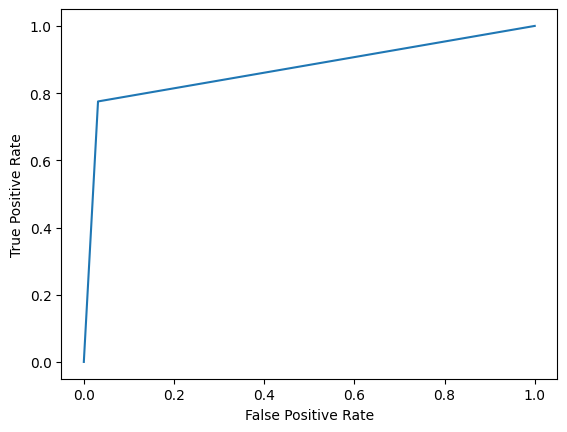

  Validation Loss: 0.24
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    458.    Elapsed: 0:00:09.
  Batch    80  of    458.    Elapsed: 0:00:18.
  Batch   120  of    458.    Elapsed: 0:00:27.
  Batch   160  of    458.    Elapsed: 0:00:36.
  Batch   200  of    458.    Elapsed: 0:00:44.
  Batch   240  of    458.    Elapsed: 0:00:54.
  Batch   280  of    458.    Elapsed: 0:01:03.
  Batch   320  of    458.    Elapsed: 0:01:11.
  Batch   360  of    458.    Elapsed: 0:01:20.
  Batch   400  of    458.    Elapsed: 0:01:29.
  Batch   440  of    458.    Elapsed: 0:01:38.

  Average training loss: 0.22
  Training epoch took: 0:01:43

Running Validation...
  Accuracy: 0.93
  ROC AUC: 0.93


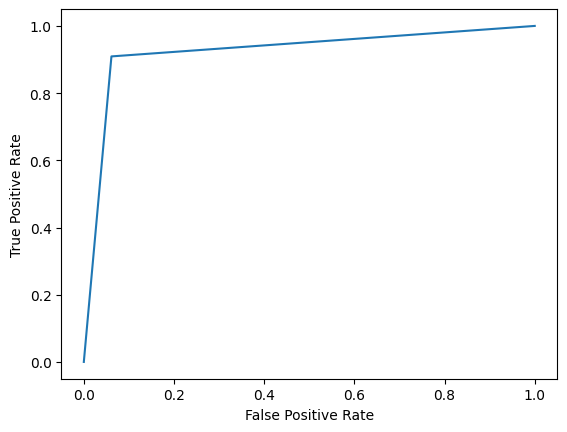

  Validation Loss: 0.19
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    458.    Elapsed: 0:00:09.
  Batch    80  of    458.    Elapsed: 0:00:18.
  Batch   120  of    458.    Elapsed: 0:00:27.
  Batch   160  of    458.    Elapsed: 0:00:36.
  Batch   200  of    458.    Elapsed: 0:00:46.
  Batch   240  of    458.    Elapsed: 0:00:55.
  Batch   280  of    458.    Elapsed: 0:01:04.
  Batch   320  of    458.    Elapsed: 0:01:13.
  Batch   360  of    458.    Elapsed: 0:01:22.
  Batch   400  of    458.    Elapsed: 0:01:31.
  Batch   440  of    458.    Elapsed: 0:01:40.

  Average training loss: 0.16
  Training epoch took: 0:01:44

Running Validation...
  Accuracy: 0.94
  ROC AUC: 0.93


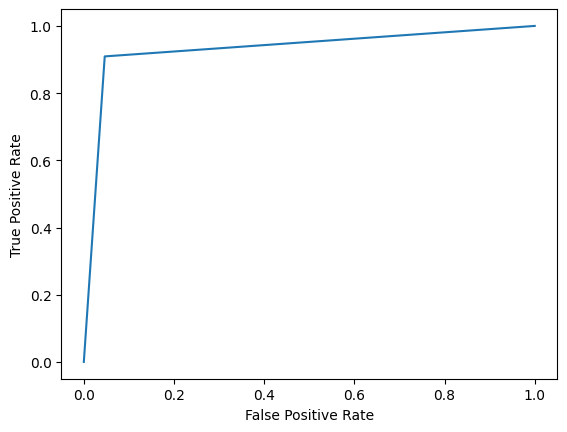

  Validation Loss: 0.17
  Validation took: 0:00:04

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    458.    Elapsed: 0:00:09.
  Batch    80  of    458.    Elapsed: 0:00:18.
  Batch   120  of    458.    Elapsed: 0:00:27.
  Batch   160  of    458.    Elapsed: 0:00:36.
  Batch   200  of    458.    Elapsed: 0:00:45.
  Batch   240  of    458.    Elapsed: 0:00:54.
  Batch   280  of    458.    Elapsed: 0:01:03.
  Batch   320  of    458.    Elapsed: 0:01:12.
  Batch   360  of    458.    Elapsed: 0:01:21.
  Batch   400  of    458.    Elapsed: 0:01:30.
  Batch   440  of    458.    Elapsed: 0:01:39.

  Average training loss: 0.14
  Training epoch took: 0:01:43

Running Validation...
  Accuracy: 0.94
  ROC AUC: 0.93


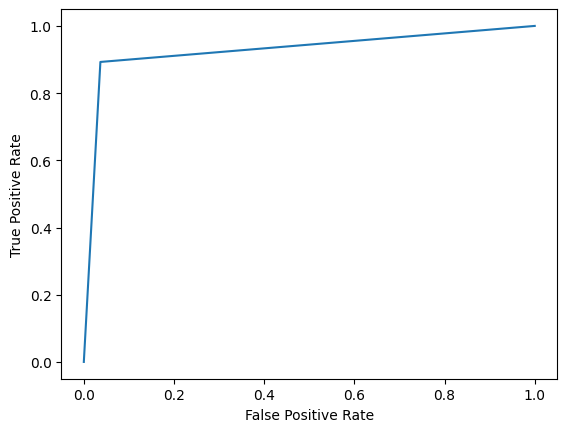

  Validation Loss: 0.17
  Validation took: 0:00:04

Training complete!
Total training took 0:07:10 (h:mm:ss)


In [22]:
import random
import matplotlib.pyplot as plt

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_rocauc = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    rocauc_exceptions = 0

    preds_global = []
    labels_global = []
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        preds_global += list(np.argmax(logits, axis=1).flatten())
        labels_global += list(label_ids.flatten())

        try:
            total_eval_rocauc += roc_auc(logits, label_ids)
        except ValueError:
            rocauc_exceptions += 1


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_rocauc = total_eval_rocauc / (len(validation_dataloader) - rocauc_exceptions)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  ROC AUC: {0:.2f}".format(avg_val_rocauc))

    fpr, tpr, _ = roc_curve(labels_global, preds_global)
    plt.plot (fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [24]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.3823311584289938,
  'Valid. Loss': 0.23760877461994395,
  'Valid. Accur.': 0.9108018207282913,
  'Training Time': '0:01:43',
  'Validation Time': '0:00:04'},
 {'epoch': 2,
  'Training Loss': 0.2158219446895815,
  'Valid. Loss': 0.18699526553060494,
  'Valid. Accur.': 0.9300595238095238,
  'Training Time': '0:01:43',
  'Validation Time': '0:00:05'},
 {'epoch': 3,
  'Training Loss': 0.16327035318506988,
  'Valid. Loss': 0.1707105882758019,
  'Valid. Accur.': 0.9405637254901961,
  'Training Time': '0:01:44',
  'Validation Time': '0:00:04'},
 {'epoch': 4,
  'Training Loss': 0.14191085312060003,
  'Valid. Loss': 0.1657817378165383,
  'Valid. Accur.': 0.9423144257703081,
  'Training Time': '0:01:43',
  'Validation Time': '0:00:04'}]

In [26]:
avg_val_rocauc

0.9312375369811319

Средний ROC AUC на последней эпохе ниже, чем у классических алгоритмов.

# Подведение итогов

In [185]:
fit_results.sort_values('roc_auc', ascending=False)

,vectorizer,model,roc_auc
4,TfidfVectorizer,RandomForestClassifier,0.953337
1,CountVectorizer,RandomForestClassifier,0.947233
0,CountVectorizer,LogisticRegression,0.946298
11,TfidfVectorizer,CatBoostClassifier,0.946216
10,CountVectorizer,CatBoostClassifier,0.944254
6,Word2Vec,CatBoostClassifier,0.930602
3,TfidfVectorizer,LogisticRegression,0.926915
9,Word2Vec,RandomForestClassifier,0.907410
5,TfidfVectorizer,KNeighborsClassifier,0.868266
8,Word2Vec,LogisticRegression,0.859121


Победил Random Forest с Tfidf. В целом можно было бы использовать любую из топ-5 моделей, т.к. разрыв по скору у них небольшой. Возьмем топ-1 модель, раз она оказалась первой. К тому же, возможно, в силу своего устройства деревья лучше и точнее вычленяют какие-то признаки "спама" и поэтому имеют более высокий скор, чем остальные алгоритмы.

Логистическая регрессия с CountVectorizer может служить хорошей альтернативой: возможно, существуют общие слова для всех "спам" текстов, и фичам, которые отвечают за них, логистическая регрессия дает больший вес.

Подход с BERT'ом оказался чуть хуже, во-первых, потому что он ограничен длинной токенов 512, во-вторых, возможно, качество предобученной модели было не таким хорошим, как могло быть, и при более тщательном подборе модели (и бОльших вычислительных мощностях) BERT мог вполне побить рекорд Random Forest'а.

Допускаю, что результаты Random Forest'а и других классических моделей могут быть улучшены с помощью подбора гиперпараметров.

Также хочу заметить, что датасет не слишком сбалансирован, и высокий roc-auc, возможно, не до конца отражает реальное качество модели, особенно если в тестовой выборке распределение отличается в пользу большего количества спама.

Перед тем, как скорить тестовые данные, обучим его на всем трейне, чтобы повысить качество.

In [188]:
df_test = pd.read_csv('test_spam.csv')
df_test['text_stemmed'] = df_test['text'].apply(preprocess_sentence_eng)
df_test.head()

,text,text_stemmed
0,j jim whitehead ejw cse ucsc edu writes j you ...,j jim whitehead ejw cse ucsc edu write j you o...
1,original message from bitbitch magnesium net p...,origin messag from bitbitch magnesium net peop...
2,java for managers vince durasoft who just taug...,java for manag vinc durasoft who just taught t...
3,there is a youtuber name saiman says,there is a youtub name saiman say
4,underpriced issue with high return on equity t...,underpr issu with high return on equiti the oi...


In [189]:
pipeline = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("model", RandomForestClassifier()),
    ]
)
pipeline.fit(df['text_stemmed'], df['text_type'])
y_pred = pipeline.predict(df_test['text_stemmed'])

In [ ]:
df_test = df_test.drop(columns=['text_stemmed'])

In [201]:
df_test['score'] = y_pred
df_test['score'] = df_test['score'].map({1 : 'spam', 0 : 'ham'})

In [202]:
df_test.head()

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,ham
1,original message from bitbitch magnesium net p...,ham
2,java for managers vince durasoft who just taug...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity t...,spam


In [203]:
df_test.to_csv('test_scores.csv')